# STEP 1: Install and Setup

In [1]:
# Install required packages
!pip install -q kaggle folium

# Upload your Kaggle API key
from google.colab import files
files.upload()  # Upload kaggle.json

# Set up Kaggle credentials
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and unzip the dataset
!kaggle datasets download -d arashnic/microsoft-geolife-gps-trajectory-dataset
!unzip -q microsoft-geolife-gps-trajectory-dataset.zip


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/arashnic/microsoft-geolife-gps-trajectory-dataset
License(s): CC0-1.0
 95% 319M/337M [00:00<00:00, 423MB/s]
100% 337M/337M [00:00<00:00, 463MB/s]


# STEP 2: Load Trajectories

In [2]:
import os
import matplotlib.pyplot as plt

# Step 2.1: Load trajectories from dataset
def load_trajectories(base_path='Geolife Trajectories 1.3/Data/', limit_users=5, min_points=20):
    sequences = []

    for user in sorted(os.listdir(base_path))[:limit_users]:
        traj_path = os.path.join(base_path, user, "Trajectory")
        for file in os.listdir(traj_path):
            with open(os.path.join(traj_path, file)) as f:
                lines = f.readlines()[6:]  # Skip header

            coords = []
            for line in lines:
                parts = line.strip().split(',')
                lat, lon = float(parts[0]), float(parts[1])
                coords.append((lat, lon))

            if len(coords) >= min_points:
                sequences.append(coords)
    return sequences




In [13]:
# Step 2.2: Load sequences and store in variable
sequences = load_trajectories(limit_users=10)



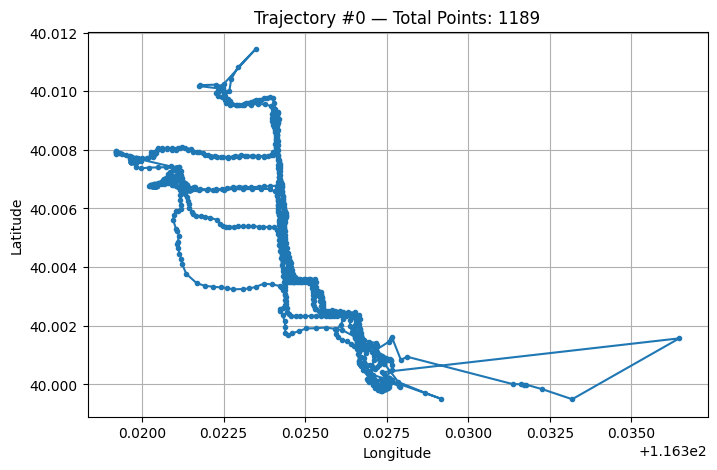

In [14]:
# Step 2.3: Plot a sample trajectory
def plot_sample_trajectory(sequences, index=0):
    coords = sequences[index]
    lats = [pt[0] for pt in coords]
    lons = [pt[1] for pt in coords]

    plt.figure(figsize=(8, 5))
    plt.plot(lons, lats, marker='o', markersize=3, linestyle='-')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Trajectory #{index} — Total Points: {len(coords)}")
    plt.grid(True)
    plt.show()

# Show one sample
plot_sample_trajectory(sequences, index=0)

# STEP 3: Normalize and Split

In [17]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Step 3.1: Prepare input-output pairs
def prepare_data(sequences, window=10):
    X, y = [], []
    for seq in sequences:
        for i in range(len(seq) - window):
            input_seq = seq[i:i+window]
            target = seq[i+window]
            X.append(input_seq)
            y.append(target)
    return np.array(X), np.array(y)

# Apply to sequences
X_raw, y_raw = prepare_data(sequences, window=10)

# Step 3.2: Normalize with MinMaxScaler
scaler = MinMaxScaler()
X_scaled = X_raw.reshape(-1, 2)  # flatten to 2D for scaler
X_scaled = scaler.fit_transform(X_scaled)
X_scaled = X_scaled.reshape(X_raw.shape)  # reshape back

y_scaled = scaler.transform(y_raw)  # target also needs to be scaled

# Step 3.3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

# Check shapes
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)


X_train: (1465676, 10, 2)
y_train: (1465676, 2)


# STEP 4: Build Models

## Step 4.1: Base LSTM Model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define base model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(2)  # output: lat, lon
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train base model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=64,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
22902/22902 ━━━━━━━━━━━━━━━━━━━━ 130s 6ms/step - loss: 0.0011 - mae: 0.0039 - val_loss: 3.7001e-06 - val_mae: 0.0017
Epoch 2/15
22902/22902 ━━━━━━━━━━━━━━━━━━━━ 141s 6ms/step - loss: 3.6185e-06 - mae: 8.2702e-04 - val_loss: 2.7713e-07 - val_mae: 1.2364e-04
Epoch 3/15
22902/22902 ━━━━━━━━━━━━━━━━━━━━ 122s 5ms/step - loss: 3.5866e-06 - mae: 5.9138e-04 - val_loss: 4.5666e-07 - val_mae: 4.1304e-04
Epoch 4/15
22902/22902 ━━━━━━━━━━━━━━━━━━━━ 141s 5ms/step - loss: 2.5847e-06 - mae: 5.5742e-04 - val_loss: 5.5103e-07 - val_mae: 5.0991e-04
Epoch 5/15
22902/22902 ━━━━━━━━━━━━━━━━━━━━ 142s 5ms/step - loss: 2.5407e-06 - mae: 4.7653e-04 - val_loss: 2.7577e-07 - val_mae: 1.0482e-04
Epoch 6/15
22902/22902 ━━━━━━━━━━━━━━━━━━━━ 127s 6ms/step - loss: 3.3242e-06 - mae: 4.6020e-04 - val_loss: 1.0153e-06 - val_mae: 8.1557e-04
Epoch 7/15
22902/22902 ━━━━━━━━━━━━━━━━━━━━ 128s 6ms/step - loss: 2.5887e-06 - mae: 4.1635e-04 - val_loss: 3.2126e-07 - val_mae: 2.3220e-04
Epoch 8/15
22902/22902 ━━━━━━━━━

## Step 4.2: Stacked LSTM Model (Variation 1)

In [19]:
# Stacked LSTM model
model_v1 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(2)
])

model_v1.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train stacked model
history_v1 = model_v1.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=64,
    verbose=1
)


Epoch 1/15
22902/22902 ━━━━━━━━━━━━━━━━━━━━ 155s 7ms/step - loss: 0.0019 - mae: 0.0061 - val_loss: 8.5000e-06 - val_mae: 0.0025
Epoch 2/15
22902/22902 ━━━━━━━━━━━━━━━━━━━━ 207s 7ms/step - loss: 6.7393e-06 - mae: 0.0012 - val_loss: 1.0956e-06 - val_mae: 6.7434e-04
Epoch 3/15
22902/22902 ━━━━━━━━━━━━━━━━━━━━ 201s 7ms/step - loss: 3.6866e-06 - mae: 8.2664e-04 - val_loss: 4.2812e-07 - val_mae: 1.5632e-04
Epoch 4/15
22902/22902 ━━━━━━━━━━━━━━━━━━━━ 202s 7ms/step - loss: 3.0391e-06 - mae: 6.8801e-04 - val_loss: 3.5397e-07 - val_mae: 1.3720e-04
Epoch 5/15
22902/22902 ━━━━━━━━━━━━━━━━━━━━ 199s 7ms/step - loss: 2.5894e-06 - mae: 6.2040e-04 - val_loss: 3.3051e-07 - val_mae: 1.0256e-04
Epoch 6/15
22902/22902 ━━━━━━━━━━━━━━━━━━━━ 205s 7ms/step - loss: 2.6738e-06 - mae: 5.1743e-04 - val_loss: 6.0526e-07 - val_mae: 3.9101e-04
Epoch 7/15
22902/22902 ━━━━━━━━━━━━━━━━━━━━ 202s 7ms/step - loss: 2.9018e-06 - mae: 6.0431e-04 - val_loss: 1.1430e-06 - val_mae: 8.7157e-04
Epoch 8/15
22902/22902 ━━━━━━━━━━━━━

## Step 4.3: Bidirectional LSTM Model (Variation 2)

In [20]:
from tensorflow.keras.layers import Bidirectional

# Bidirectional LSTM model
model_v2 = Sequential([
    Bidirectional(LSTM(64), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(2)
])

model_v2.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train bidirectional model
history_v2 = model_v2.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=64,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
22902/22902 ━━━━━━━━━━━━━━━━━━━━ 167s 7ms/step - loss: 0.0026 - mae: 0.0057 - val_loss: 7.4972e-07 - val_mae: 1.3523e-04
Epoch 2/15
22902/22902 ━━━━━━━━━━━━━━━━━━━━ 199s 7ms/step - loss: 3.0683e-06 - mae: 7.7719e-04 - val_loss: 1.2169e-06 - val_mae: 8.4611e-04
Epoch 3/15
22902/22902 ━━━━━━━━━━━━━━━━━━━━ 201s 7ms/step - loss: 3.1822e-06 - mae: 6.0211e-04 - val_loss: 6.5504e-07 - val_mae: 5.9523e-04
Epoch 4/15
22902/22902 ━━━━━━━━━━━━━━━━━━━━ 160s 7ms/step - loss: 2.0058e-06 - mae: 5.2401e-04 - val_loss: 3.3699e-07 - val_mae: 1.8357e-04
Epoch 5/15
22902/22902 ━━━━━━━━━━━━━━━━━━━━ 201s 7ms/step - loss: 2.0929e-06 - mae: 5.1918e-04 - val_loss: 6.5698e-07 - val_mae: 5.8808e-04
Epoch 6/15
22902/22902 ━━━━━━━━━━━━━━━━━━━━ 200s 7ms/step - loss: 1.8267e-06 - mae: 4.3695e-04 - val_loss: 2.8810e-07 - val_mae: 5.1225e-05
Epoch 7/15
22902/22902 ━━━━━━━━━━━━━━━━━━━━ 204s 7ms/step - loss: 3.2728e-06 - mae: 4.2448e-04 - val_loss: 3.1916e-07 - val_mae: 1.5569e-04
Epoch 8/15
22902/22902 ━━━━━

# Step 5: Haversine Distance Comparison

In [21]:
from math import radians, sin, cos, sqrt, atan2

# Step 5.1: Define Haversine function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c * 1000  # return in meters

# Step 5.2: Evaluate Haversine distance for full sets
def evaluate_haversine(y_true, y_pred):
    total = 0
    for i in range(len(y_true)):
        total += haversine(y_true[i][0], y_true[i][1], y_pred[i][0], y_pred[i][1])
    return total / len(y_true)


In [22]:
# Inverse transform the scaled predictions and labels
y_true_inv = scaler.inverse_transform(y_test)

y_pred_base = scaler.inverse_transform(model.predict(X_test))
y_pred_v1 = scaler.inverse_transform(model_v1.predict(X_test))
y_pred_v2 = scaler.inverse_transform(model_v2.predict(X_test))

# Step 5.4: Calculate Haversine error for each model
base_error = evaluate_haversine(y_true_inv, y_pred_base)
v1_error = evaluate_haversine(y_true_inv, y_pred_v1)
v2_error = evaluate_haversine(y_true_inv, y_pred_v2)

# Step 5.5: Print Results
print(f"Base LSTM Haversine Error      : {base_error:.2f} meters")
print(f"Stacked LSTM Haversine Error   : {v1_error:.2f} meters")
print(f"Bidirectional LSTM Error       : {v2_error:.2f} meters")


11451/11451 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step
11451/11451 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step
11451/11451 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step
Base LSTM Haversine Error      : 75.82 meters
Stacked LSTM Haversine Error   : 726.61 meters
Bidirectional LSTM Error       : 1570.48 meters


Step 6

In [23]:
!pip install -q folium
import folium


In [24]:
def show_map(y_true, y_pred, index=0):
    true_lat, true_lon = y_true[index]
    pred_lat, pred_lon = y_pred[index]

    # Center map on actual location
    m = folium.Map(location=[true_lat, true_lon], zoom_start=15)

    # Add true point (green)
    folium.Marker(
        location=[true_lat, true_lon],
        popup="True Location",
        icon=folium.Icon(color='green')
    ).add_to(m)

    # Add predicted point (red)
    folium.Marker(
        location=[pred_lat, pred_lon],
        popup="Predicted Location",
        icon=folium.Icon(color='red')
    ).add_to(m)

    # Line between true and predicted
    folium.PolyLine(
        locations=[[true_lat, true_lon], [pred_lat, pred_lon]],
        color='blue',
        weight=2
    ).add_to(m)

    return m


In [25]:
# View predictions from Base Model
show_map(y_true_inv, y_pred_base, index=0)


In [26]:
# Stacked LSTM
show_map(y_true_inv, y_pred_v1, index=5)

# Bidirectional LSTM
show_map(y_true_inv, y_pred_v2, index=10)


In [27]:
# Save base LSTM model
model.save("geolife_base_lstm.h5")

# Save stacked LSTM model
model_v1.save("geolife_stacked_lstm.h5")

# Save bidirectional LSTM model
model_v2.save("geolife_bidir_lstm.h5")


In [29]:
import pandas as pd

# Create DataFrame for comparison
df_preds = pd.DataFrame({
    'True_Lat': y_true_inv[:, 0],
    'True_Lon': y_true_inv[:, 1],
    'Base_Lat': y_pred_base[:, 0],
    'Base_Lon': y_pred_base[:, 1],
    'Stacked_Lat': y_pred_v1[:, 0],
    'Stacked_Lon': y_pred_v1[:, 1],
    'Bidir_Lat': y_pred_v2[:, 0],
    'Bidir_Lon': y_pred_v2[:, 1],
})

# Save to CSV
df_preds.to_csv("rnn_trajectory_predictions.csv", index=False)


In [30]:
# Print sample from the saved DataFrame
df_preds.head()


,True_Lat,True_Lon,Base_Lat,Base_Lon,Stacked_Lat,Stacked_Lon,Bidir_Lat,Bidir_Lon
0,31.999368,120.842747,31.999062,120.843102,32.023876,120.843208,31.989731,120.839142
1,39.980779,116.334723,39.980606,116.335197,39.985470,116.338493,39.966888,116.328979
2,39.990778,116.312941,39.990688,116.313278,39.995426,116.316780,39.976856,116.307091
3,39.917049,116.345163,39.917320,116.345787,39.923000,116.348930,39.903698,116.339584
4,40.011006,116.321726,40.010918,116.322083,40.015465,116.325577,39.997223,116.315956


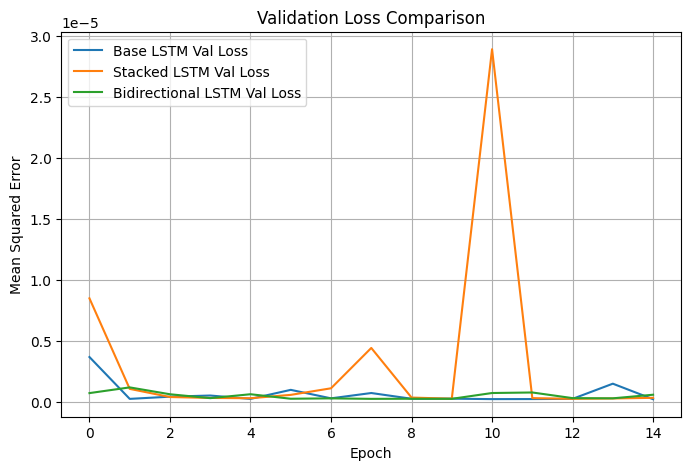

In [31]:
import matplotlib.pyplot as plt

def compare_loss(histories, labels):
    plt.figure(figsize=(8, 5))
    for h, label in zip(histories, labels):
        plt.plot(h.history['val_loss'], label=f'{label} Val Loss')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True)
    plt.show()

compare_loss(
    histories=[history, history_v1, history_v2],
    labels=['Base LSTM', 'Stacked LSTM', 'Bidirectional LSTM']
)


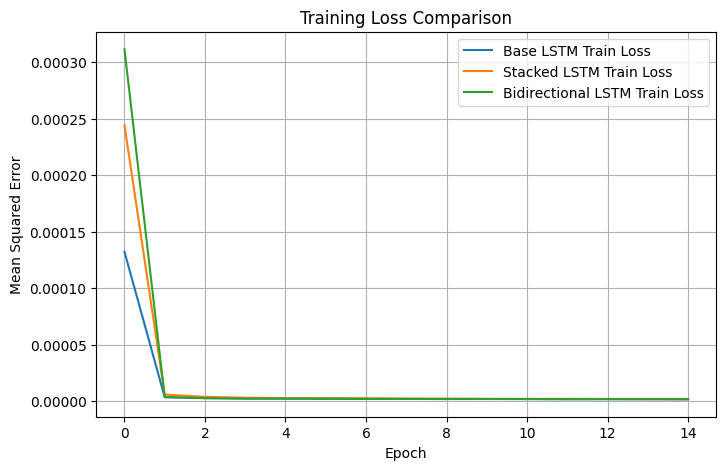

In [32]:
def compare_train_loss(histories, labels):
    plt.figure(figsize=(8, 5))
    for h, label in zip(histories, labels):
        plt.plot(h.history['loss'], label=f'{label} Train Loss')
    plt.title('Training Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True)
    plt.show()

compare_train_loss(
    histories=[history, history_v1, history_v2],
    labels=['Base LSTM', 'Stacked LSTM', 'Bidirectional LSTM']
)


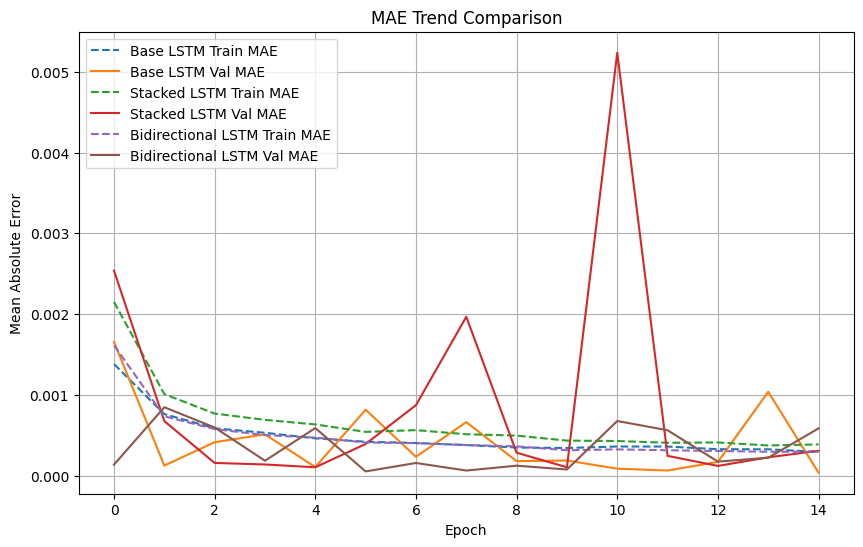

In [33]:
def compare_mae_trends(histories, labels):
    plt.figure(figsize=(10, 6))

    for h, label in zip(histories, labels):
        plt.plot(h.history['mae'], linestyle='--', label=f'{label} Train MAE')
        plt.plot(h.history['val_mae'], label=f'{label} Val MAE')

    plt.title('MAE Trend Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function with your histories
compare_mae_trends(
    histories=[history, history_v1, history_v2],
    labels=['Base LSTM', 'Stacked LSTM', 'Bidirectional LSTM']
)
